In [2]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.metrics import r2_score

california_housing = fetch_california_housing(as_frame=True)
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

/home/jaeho/junior_fall/frequentist/project_4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


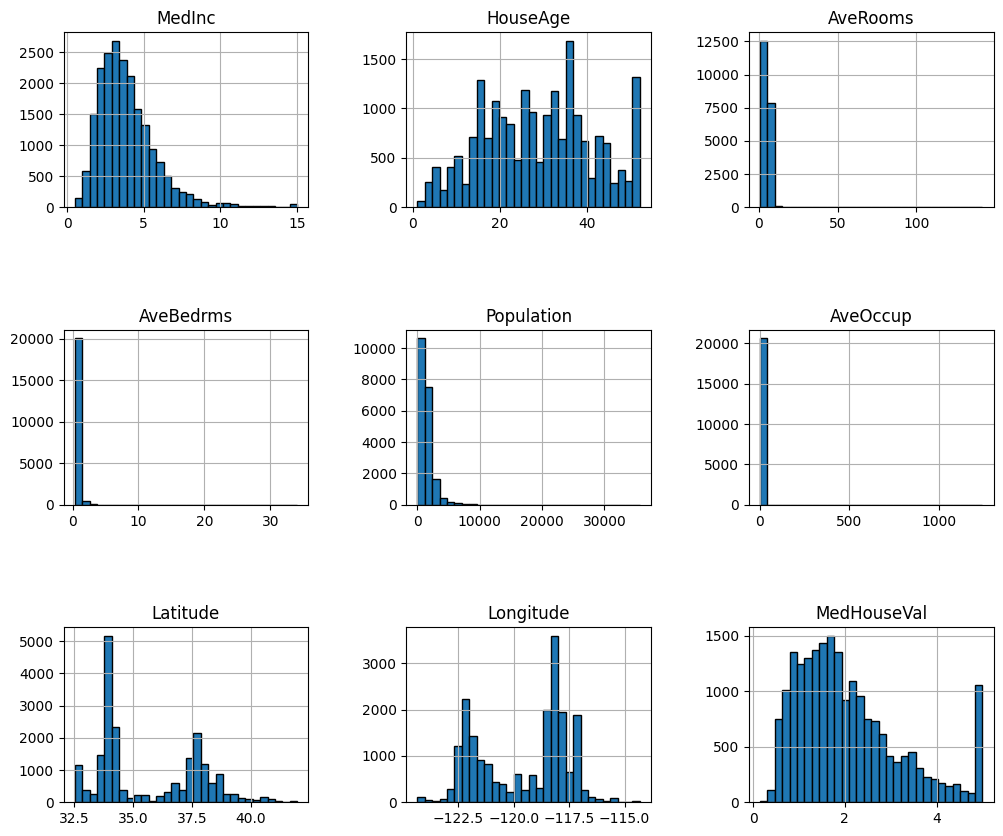

In [3]:
california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

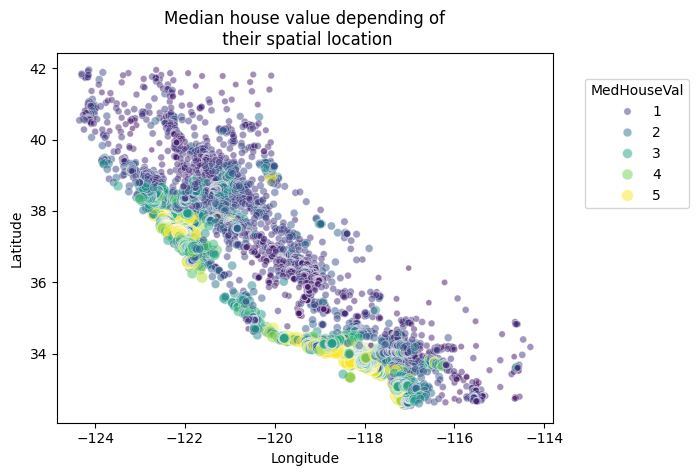

In [4]:
sns.scatterplot(
    data=california_housing.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

In [5]:
# Load California housing dataset
data = california_housing
X, y = data.data, data.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

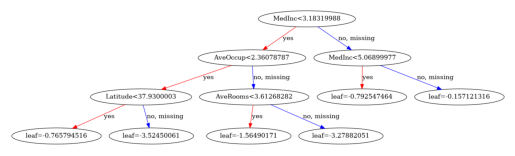

In [6]:
# Set parameters for XGBoost
params = {
    'objective': 'reg:pseudohubererror',
    'learning_rate': 0.1,
    'max_leaves': 6,
    'eval_metric': 'mae',
}

# Train the model
evals_result = {}
xgb_booster = xgb.train(
    params,
    dtrain,
    num_boost_round=800,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    evals_result=evals_result,
    verbose_eval=False
)
xgb.plot_tree(xgb_booster)
plt.show()


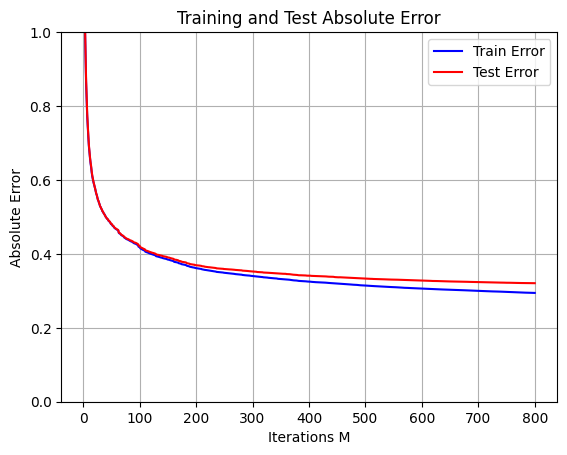

0.3207076652942933

In [7]:
# Extract mean absolute error for both train and test sets for each iteration
train_mae = evals_result['train']['mae']
test_mae = evals_result['test']['mae']
iterations = range(1, len(train_mae) + 1)

# Plot train and test errors as a function of number of iterations
plt.plot(iterations, train_mae, linestyle='-', color='blue', label='Train Error')
plt.plot(iterations, test_mae, linestyle='-', color='red', label='Test Error')
plt.ylim(0, 1)
plt.xlabel("Iterations M")
plt.ylabel("Absolute Error")
plt.title("Training and Test Absolute Error")
plt.legend()
plt.grid()
plt.show()
test_mae[-1]


In [8]:
predictions = xgb_booster.predict(dtest)
r2_score(y_test, predictions)

0.8259683628950589

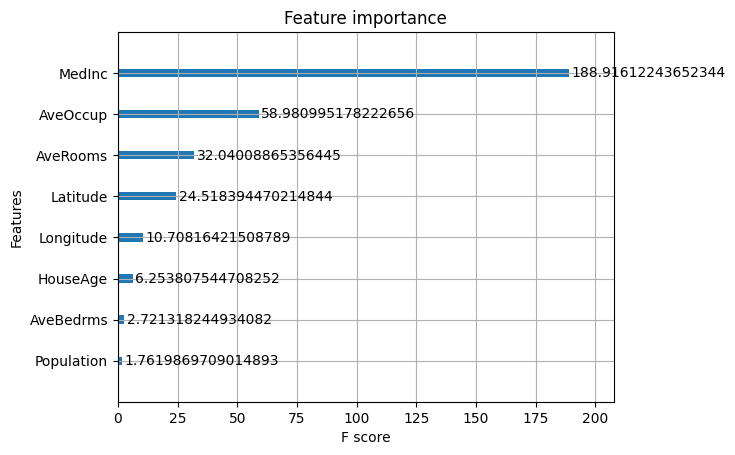

In [9]:
# Get feature importances
importance = xgb_booster.get_fscore()
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

xgb.plot_importance(xgb_booster, importance_type='gain')
plt.show()

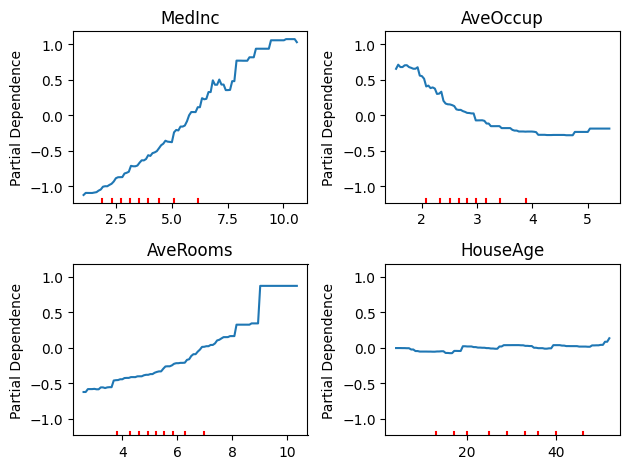

In [10]:
class PartialDependenceCalculator:
    def __init__(self, model, X, feature_name, grid_resolution=100):
        self.model = model
        self.X = X
        self.feature_name = feature_name
        self.grid_resolution = grid_resolution

    def calculate_partial_dependence(self):
        X_copy = self.X.copy()
        feature_values = self.X[self.feature_name]
        feature_value_limits = feature_values.quantile([0.01, 0.99])
        grid_values = np.linspace(feature_value_limits[0.01], feature_value_limits[0.99], self.grid_resolution)
        deciles = feature_values.quantile(np.arange(0.1, 1, 0.1))
        
        pd_values = []
        for value in grid_values:
            X_copy[self.feature_name] = value
            preds = self.model.predict(xgb.DMatrix(X_copy))
            pd_values.append(np.mean(preds))
        
        pd_centered = pd_values - np.mean(pd_values)
        return grid_values, pd_centered, deciles

    def plot(self, ax):
        grid_values, pd_centered, deciles = self.calculate_partial_dependence()

        ax.plot(grid_values, pd_centered)
        ax.set_title(self.feature_name)
        ax.set_ylabel("Partial Dependence")

        # Add hash marks at the deciles
        for decile in deciles:
            ax.axvline(decile, ymax=0.02, color="red")

# Plot partial dependence for selected features
nonlocation_features = [f for f in sorted_importance.keys() if f not in ['Latitude', 'Longitude']]
selected_features = nonlocation_features[:4]

fig, axs = plt.subplots(2, 2)
widest_ylim = None
for i, feature_name in enumerate(selected_features):
    ax = axs[i // 2, i % 2]
    pdc = PartialDependenceCalculator(xgb_booster, X, feature_name)
    pdc.plot(ax)

    current_ylim = ax.get_ylim()
    if widest_ylim is None:
        widest_ylim = current_ylim
    else:
        widest_ylim = (min(widest_ylim[0], current_ylim[0]), max(widest_ylim[1], current_ylim[1]))

# Set the widest ylim for all axes
for ax in axs.flat:
    ax.set_ylim(widest_ylim)

plt.tight_layout()

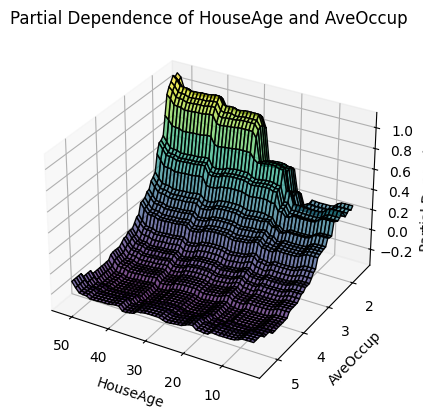

In [11]:
class DualPartialDependenceCalculator:
    def __init__(self, model, X, feature_names, grid_resolution=50):
        self.model = model
        self.X = X
        self.feature_names = feature_names
        self.grid_resolution = grid_resolution

    def calculate_partial_dependence(self):
        X_copy = self.X.copy()
        
        # Define the grid for each feature
        feature_values = [self.X[feature] for feature in self.feature_names]
        feature_limits = [feature.quantile([0.01, 0.99]) for feature in feature_values]
        
        grid_values_1 = np.linspace(feature_limits[0][0.01], feature_limits[0][0.99], self.grid_resolution)
        grid_values_2 = np.linspace(feature_limits[1][0.01], feature_limits[1][0.99], self.grid_resolution)
        
        # Create mesh grid for two-feature partial dependence
        grid_x, grid_y = np.meshgrid(grid_values_1, grid_values_2)
        
        # Calculate partial dependence for each point in the 2D grid
        pd_values = np.zeros_like(grid_x)
        for i in range(self.grid_resolution):
            for j in range(self.grid_resolution):
                X_copy[self.feature_names[0]] = grid_x[i, j]
                X_copy[self.feature_names[1]] = grid_y[i, j]
                preds = self.model.predict(xgb.DMatrix(X_copy))
                pd_values[i, j] = np.mean(preds)
        
        # Center the partial dependence values
        pd_centered = pd_values - np.mean(pd_values)
        
        return grid_x, grid_y, pd_centered

    def plot(self, ax):
        grid_x, grid_y, pd_centered = self.calculate_partial_dependence()
        
        # Plot the partial dependence as a 3D surface plot
        ax.plot_surface(grid_x, grid_y, pd_centered, cmap="viridis", edgecolor="k", alpha=0.7)
        
        ax.set_title(f"Partial Dependence of {self.feature_names[0]} and {self.feature_names[1]}")
        ax.set_xlabel(self.feature_names[0])
        ax.set_ylabel(self.feature_names[1])
        ax.set_zlabel("Partial Dependence")

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
dpdc = DualPartialDependenceCalculator(xgb_booster, X, feature_names=["HouseAge", "AveOccup"])
dpdc.plot(ax)
ax.view_init(azim=120)
plt.show()

In [12]:
perform_sklearn_pdp = False
def sklearn_pdp(model, X, sorted_importance):
    from sklearn.inspection import PartialDependenceDisplay
    from sklearn.inspection import partial_dependence

    # Initialize sklearn compatible XGBoost regressor
    model.save_model('xgb.json')
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.load_model(fname='xgb.json')

    # Plot partial dependence for selected features
    nonlocation_features = [f for f in sorted_importance.keys() if f not in ['Latitude', 'Longitude']]
    selected_features = nonlocation_features[:4]

    fig, ax = plt.subplots(2, 2, figsize=(7, 7))
    PartialDependenceDisplay.from_estimator(xgb_reg, X, features=selected_features, ax=ax)
    plt.suptitle("Partial Dependence of Housing Value on Selected Features")
    plt.show()

    # Compute partial dependence for 'HouseAge' and 'AveOccup'
    pdp_result = partial_dependence(xgb_reg, X_train, features=['HouseAge', 'AveOccup'], grid_resolution=50)

    # Prepare grid for 3D plotting
    age_grid, occup_grid = np.meshgrid(pdp_result['grid_values'][0], pdp_result['grid_values'][1])
    pdp_average = pdp_result['average'][0]

    # Plot 3D Partial Dependence Plot
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 7))
    ax.plot_surface(age_grid, occup_grid, pdp_average, cmap='viridis')

    # Label axes
    ax.set_xlabel('HouseAge')
    ax.set_ylabel('AveOccup')
    ax.set_zlabel('Partial Dependence')
    plt.show()
if perform_sklearn_pdp:
    sklearn_pdp(xgb_booster, X, sorted_importance)


In [13]:
insurance_path = kagglehub.dataset_download("mirichoi0218/insurance")
insurance = pd.read_csv(insurance_path + "/insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


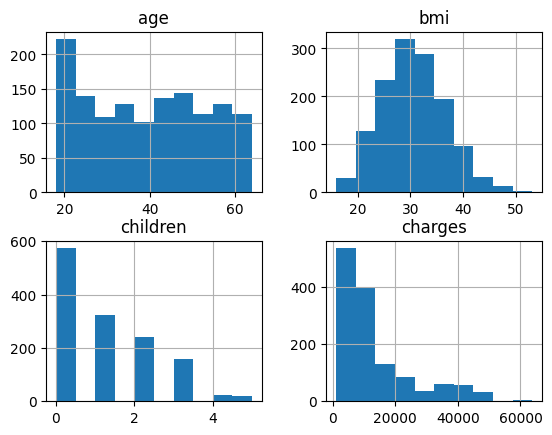

In [14]:
insurance.hist()
plt.show()


In [15]:
# Convert categorical columns to dummy variables
insurance = pd.get_dummies(insurance, drop_first=True)

# Split data into features and target
X = insurance.drop(columns="charges")
y = insurance["charges"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [16]:
# Initial parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'eta': 0.1, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Perform cross-validation with early stopping
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    as_pandas=True,
)

# Retrieve the best iteration
best_num_boost_round = cv_results['test-rmse-mean'].argmin()
print("Best number of boosting rounds:", best_num_boost_round)
print("Best RMSE:", cv_results['test-rmse-mean'].min())

Best number of boosting rounds: 53
Best RMSE: 4775.68387814754


In [17]:
best_rmse = float("Inf")
best_params = {}

for max_depth in range(3, 10, 2):
    for min_child_weight in range(1, 6, 2):
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            nfold=5,
            early_stopping_rounds=50,
            metrics="rmse",
            as_pandas=True,
        )
        mean_rmse = cv_results['test-rmse-mean'].min()
        print(f"max_depth: {max_depth}, min_child_weight: {min_child_weight}, RMSE: {mean_rmse}")
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

params.update(best_params)
print("Best parameters:", best_params, "RMSE:", best_rmse)

max_depth: 3, min_child_weight: 1, RMSE: 4480.905967117424
max_depth: 3, min_child_weight: 3, RMSE: 4474.007803693546
max_depth: 3, min_child_weight: 5, RMSE: 4477.554528218265
max_depth: 5, min_child_weight: 1, RMSE: 4775.68387814754
max_depth: 5, min_child_weight: 3, RMSE: 4715.888269323824
max_depth: 5, min_child_weight: 5, RMSE: 4691.097138301353
max_depth: 7, min_child_weight: 1, RMSE: 5037.726751050437
max_depth: 7, min_child_weight: 3, RMSE: 4966.259086607884
max_depth: 7, min_child_weight: 5, RMSE: 4867.679613330302
max_depth: 9, min_child_weight: 1, RMSE: 5374.888224448586
max_depth: 9, min_child_weight: 3, RMSE: 5171.912275025321
max_depth: 9, min_child_weight: 5, RMSE: 4951.803833310559
Best parameters: {'max_depth': 3, 'min_child_weight': 3} RMSE: 4474.007803693546


In [18]:
best_rmse = float("Inf")
best_params = {}

for subsample in [0.6, 0.8, 1.0]:
    for colsample_bytree in [0.6, 0.8, 1.0]:
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            nfold=5,
            early_stopping_rounds=50,
            metrics="rmse",
            as_pandas=True,
        )
        mean_rmse = cv_results['test-rmse-mean'].min()
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_params = {'subsample': subsample, 'colsample_bytree': colsample_bytree}
        print(f"subsample: {subsample}, colsample_bytree: {colsample_bytree}, RMSE: {mean_rmse}")

params.update(best_params)
print("Best parameters for subsample and colsample_bytree:", best_params, "RMSE:", best_rmse)

subsample: 0.6, colsample_bytree: 0.6, RMSE: 4681.967629308136
subsample: 0.6, colsample_bytree: 0.8, RMSE: 4508.109717184949
subsample: 0.6, colsample_bytree: 1.0, RMSE: 4420.988390606058
subsample: 0.8, colsample_bytree: 0.6, RMSE: 4632.6889647787775
subsample: 0.8, colsample_bytree: 0.8, RMSE: 4474.007803693546
subsample: 0.8, colsample_bytree: 1.0, RMSE: 4405.886017830585
subsample: 1.0, colsample_bytree: 0.6, RMSE: 4639.076904097662
subsample: 1.0, colsample_bytree: 0.8, RMSE: 4461.077709277726
subsample: 1.0, colsample_bytree: 1.0, RMSE: 4413.339737396434
Best parameters for subsample and colsample_bytree: {'subsample': 0.8, 'colsample_bytree': 1.0} RMSE: 4405.886017830585


In [19]:
params['learning_rate'] = 0.01
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,    # Increase rounds due to lower learning rate
    nfold=5,
    early_stopping_rounds=50,
    metrics="rmse",
    as_pandas=True,
)
best_num_boost_round = cv_results['test-rmse-mean'].argmin()
print("Best num_boost_round with lower learning rate:", best_num_boost_round)
print("Best RMSE with lower learning rate:", cv_results['test-rmse-mean'].min())


Best num_boost_round with lower learning rate: 442
Best RMSE with lower learning rate: 4397.987930458609


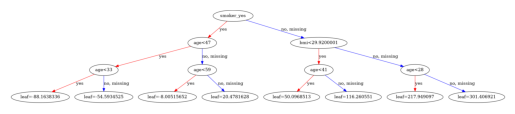

In [20]:
# Train the model
evals_result = {}
xgb_booster = xgb.train(
    params,
    dtrain,
    num_boost_round=800,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    evals_result=evals_result,
    verbose_eval=False
)
xgb.plot_tree(xgb_booster)
plt.show()

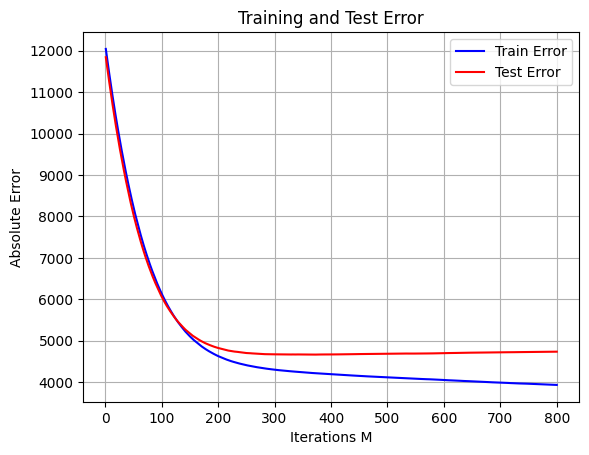

Final Test RMSE: 0.3207076652942933
R^2 Score: 0.842748890531709


In [21]:
# %% Model Evaluation
# Extract mean absolute error for both train and test sets for each iteration
train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']
iterations = range(1, len(train_rmse) + 1)

# Plot train and test errors as a function of number of iterations
plt.plot(iterations, train_rmse, linestyle='-', color='blue', label='Train Error')
plt.plot(iterations, test_rmse, linestyle='-', color='red', label='Test Error')
plt.xlabel("Iterations M")
plt.ylabel("Absolute Error")
plt.title("Training and Test Error")
plt.legend()
plt.grid()
plt.show()
print(f"Final Test RMSE: {test_mae[-1]}")

# R^2 Score
predictions = xgb_booster.predict(dtest)
print(f"R^2 Score: {r2_score(y_test, predictions)}")


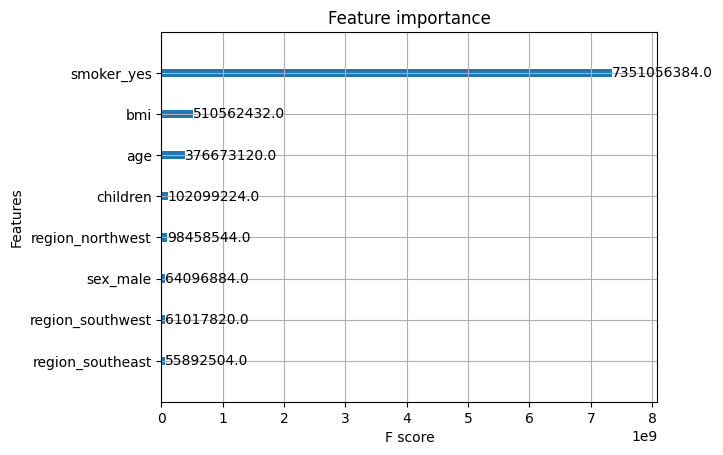

In [31]:
# Feature Importance
importance = xgb_booster.get_score(importance_type='gain')
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

xgb.plot_importance(xgb_booster, importance_type='gain')
plt.show()


smoking intuitively has a significant impact on the insurance cost. But it is more extreme than I expected.

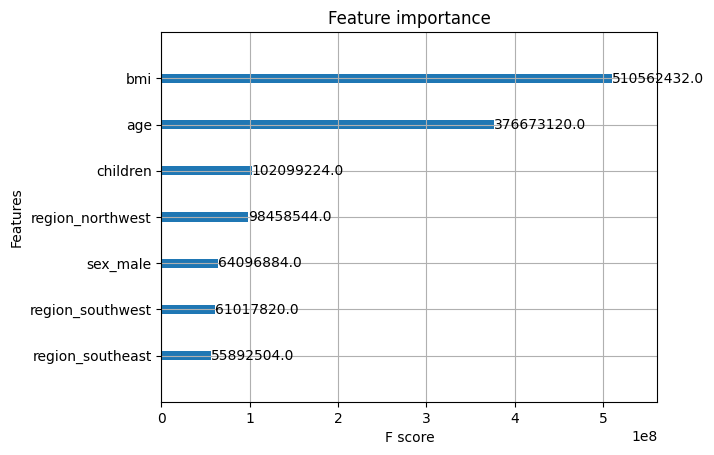

In [32]:
# Feature Importance without smoker_yes
sorted_importance_no_smoker = {k: v for k, v in sorted_importance.items() if 'smoker_yes' not in k}

xgb.plot_importance(sorted_importance_no_smoker)
plt.show()


again, bmi and age are intuitively more important than other features. 

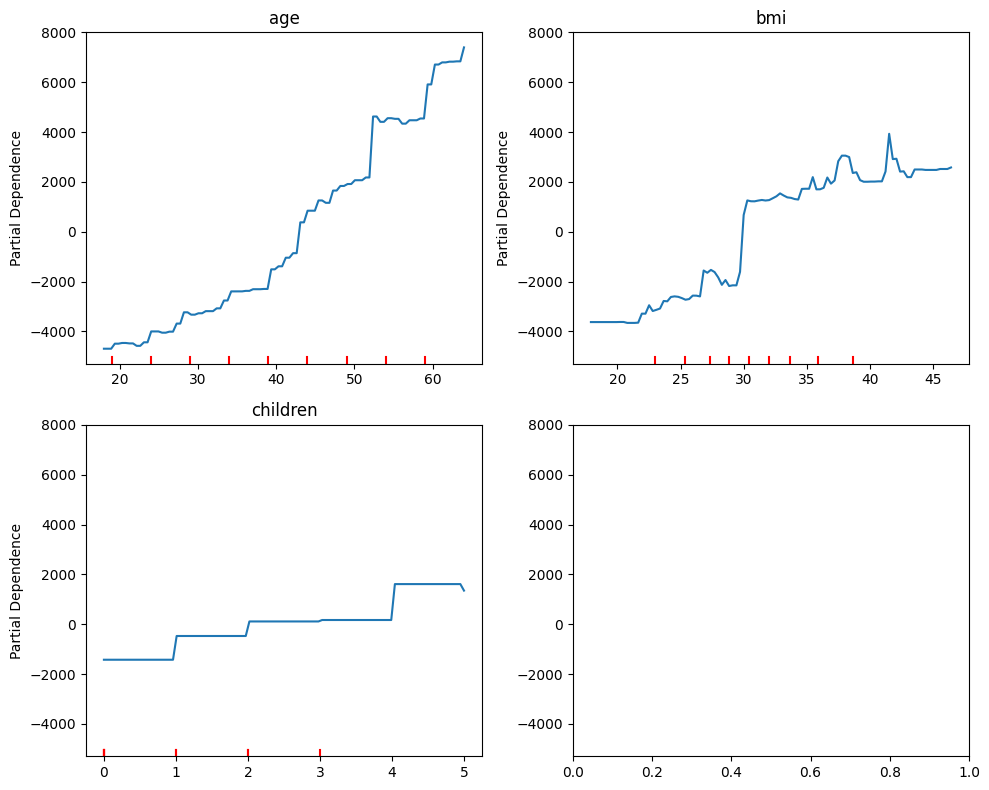

In [24]:
# Plot partial dependence for numerical features
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
widest_ylim = None
for i, feature_name in enumerate(numerical_features):
    ax = axs[i // 2, i % 2]
    pdc = PartialDependenceCalculator(xgb_booster, X, feature_name)
    pdc.plot(ax)

    current_ylim = ax.get_ylim()
    if widest_ylim is None:
        widest_ylim = current_ylim
    else:
        widest_ylim = (min(widest_ylim[0], current_ylim[0]), max(widest_ylim[1], current_ylim[1]))

# Set the widest ylim for all axes
for ax in axs.flat:
    ax.set_ylim(widest_ylim)

plt.tight_layout()
plt.show()


partial dependence plot of age unsurprisingly increases monotonically
bmi has a sharp increase at bmi=30, which is the threshold for obesity

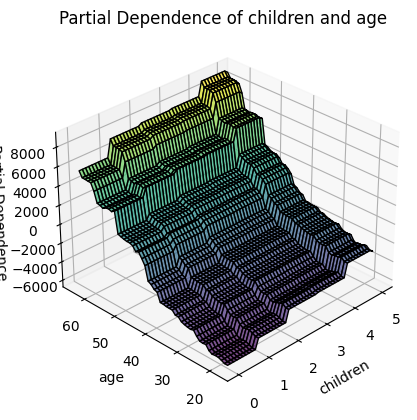

In [25]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
dpdc = DualPartialDependenceCalculator(xgb_booster, X, feature_names=["children", "age"])
dpdc.plot(ax)
ax.view_init(azim=-135)
plt.show()

no noticeable interaction between age and number of children

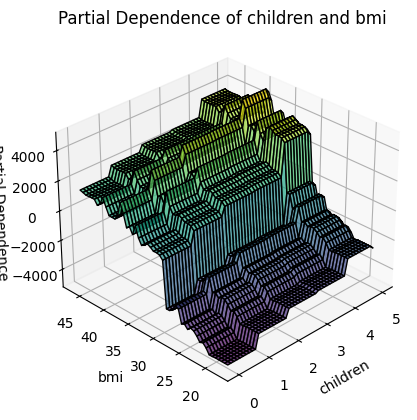

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
dpdc = DualPartialDependenceCalculator(xgb_booster, X, feature_names=["children", "bmi"])
dpdc.plot(ax)
ax.view_init(azim=-135)
plt.show()

change of partial dependence increases more when number of children goes from 4 to 5 for bmi greater than 30

In [35]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot for global feature importance
shap.summary_plot(shap_values, X_test)  # Beeswarm plot for detailed SHAP value distribution

# Detailed feature impact for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.1.